# Evaluating Model Fit

# DO WORK
- Bring up the lesson 7 notebook (git pull)
- Review the bias-variance article if you have time
http://scott.fortmann-roe.com/docs/BiasVariance.html

# LEARNING OBJECTIVES

After this lesson, you will be able to:

- Define Loss Functions and describe Mean Squared Error
- Define Cross Validation and describe K-Folds
- Use Regularization to prevent Overfitting
- Perform Grid Search for Hyperparameter Tuning
- Understand the Stochastic Gradient Descent Algorithm

# STUDENT PRE-WORK

Before this lesson, you should already be able to:

- Have a sense of goodness of fit (r-squared)
- Measure statistical significance of features
- Recall what a residual is
- Implement an sklearn estimator to predict a target variable

# MODEL EVALUATION
Objective: Get an overview of how we can check whether our model will work in the real world

Our goal in Machine Learning is to create models that generalize well or have low **generalization error**. That means we can make models that make correct predictions on new future data.

**Overfitting**
- It's possible to make a model that explains our sampled data very well, but if we get new data the model might fail.
- We've explained the idiosyncracies or noise in our data very well
  - Unfortunately, they are just that, idiosyncracies, and won't appear again since they do not reflect a true relationship
  
**Underfitting**
- We don't explain our current data very well and we don't explain our future data very well either.

**How can we test for either issue?**

**Train Test Split**

We Take our sample data and split it into two parts
- **Training data** that we can fit model coefficients on
- **Testing data** that we can use to check our predictions

This simulates new data by training our model on only a portion of our sampled data and leaving a portion for testing
- If our performance on our training data is better than our testing data, we know we've overfit.
- If the performance is the same, we may be underfitting.

### BIAS
A closely related concept is bias, roughly, how on target our model is or how well it fits our training data
- 0 bias means we predict every point perfectly, we call this low bias
- There is no upper limit on how large bias can be

### KNOWLEDGE CHECK
We made a model that works well on our data and explains the relationships that we see perfectly. We send it out to the production team. Several weeks later, people are complaining about the prediction algorithm and say that it is clearly wrong and is annoying customers.

- Are we likely overfitting or underfitting?
- Is the model likely high bias or low bias?

<!-- Answer: Overfitting. It's likely a low bias model because it fits our training data very well. -->

## EXAMPLE: UNDERFITTING AND OVERFITTING
Objective: Demonstrate what underfitting and overfitting look like

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
mammals = pd.read_csv('assets/dataset/msleep/msleep.csv')
mammals.dropna(subset=['brainwt', 'bodywt'], inplace=True)
mammals = mammals[['brainwt', 'bodywt']].copy()
mammals.shape
mammals.describe()

,brainwt,bodywt
count,56.000000,56.000000
mean,0.281581,202.981768
std,0.976414,945.856609
min,0.000140,0.005000
25%,0.002900,0.290000
50%,0.012400,2.250000
75%,0.125500,27.301250
max,5.712000,6654.000000


## CONSIDER UNDERFITTING

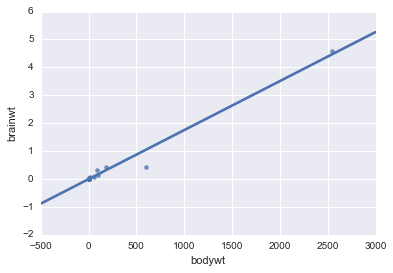

In [3]:
for i in range(1):
    sns.regplot('bodywt', 'brainwt', mammals.sample(20), order=1, ci=None)

## CONSIDER OVERFITTING

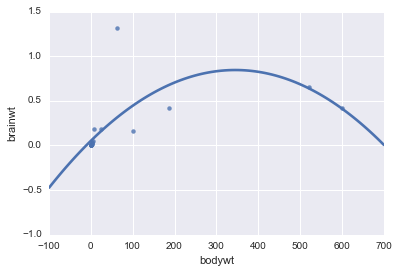

In [5]:
for i in range(1):
    sns.regplot('bodywt', 'brainwt', mammals.sample(20), order=2, ci=None)

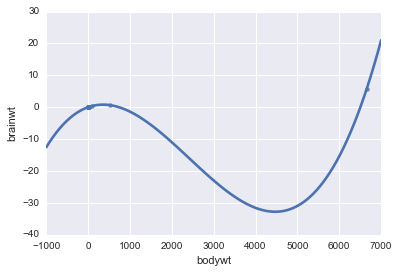

In [7]:
for i in range(1):
    sns.regplot('bodywt', 'brainwt', mammals.sample(20), order=3, ci=None)

### KNOWLEDGE CHECK

- What makes the chart above an overfit?
<!-- Answer: At this point we are just making things up, there's no evidence that bodywt and brainwt have a polynomial relationship (note, the chart changes) -->

# LINEAR MODELS AND ERROR
Objective: Learn a set of tools for measuring the performance of a model to later use with the general model evaluation procedure

### How do we actually measure the performance of a model?

### RECALL:  WHAT’S RESIDUAL ERROR?
![residuals](assets/images/residuals.png)

The distance between our predictions and the actual values in the data.

More formally:
$$residual_i = y_i - \hat{y}_i$$

$$\epsilon_i = y_i - f(x_i)$$

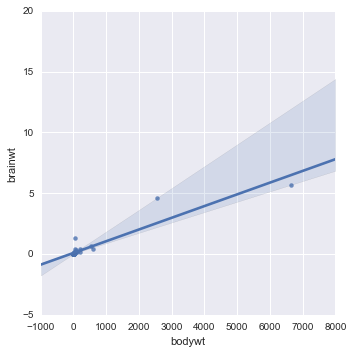

In [8]:
# Here is the familar mammals linear regression
sns.lmplot('bodywt', 'brainwt', mammals)

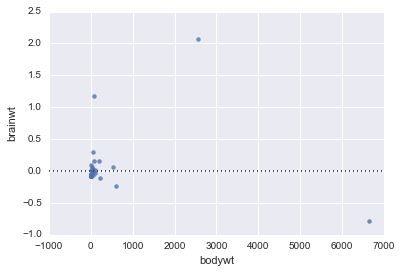

In [9]:
# Here are the residuals
sns.residplot('bodywt', 'brainwt', mammals)

## EXERCISE: CALCULATE RESIDUAL ERROR

In [10]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

mammals = pd.read_csv('assets/dataset/msleep/msleep.csv')
mammals.dropna(subset=['brainwt', 'bodywt'], inplace=True)
mammals = mammals[['brainwt', 'bodywt']].copy()

In [27]:
lm = linear_model.LinearRegression()
X =  mammals[['bodywt']]
y = mammals['brainwt']# fill in brainwt outcome variable here
lm.fit(X, y) #What do we pass to the fit method?
y_pred = lm.predict(X) # How do we compute predictions on X
residuals = y - y_pred # use the residual formula to compute residuals
# Check your work by making sure the charts below match the ones above

In [13]:
X.head()

,bodywt
1,0.480
3,0.019
4,600.000
8,14.000
9,14.800


In [21]:
y.head()

,brainwt
1,0.01550
3,0.00029
4,0.42300
8,0.07000
9,0.09820


In [20]:
type(X)

pandas.core.frame.DataFrame

In [19]:
type(y)

pandas.core.frame.DataFrame

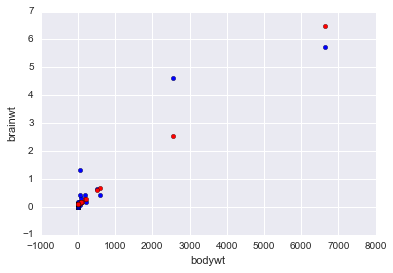

In [28]:
# This will plot your predictions in red against our data
plt.figure()
plt.scatter(X, y)
plt.scatter(X, y_pred, c='red')
plt.ylabel('brainwt')
plt.xlabel('bodywt')

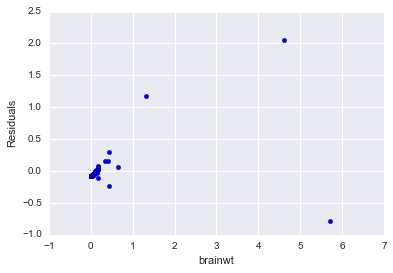

In [29]:
# This will inspect the relationship between our residuals and outcome
plt.figure()
plt.scatter(y, residuals)
plt.ylabel('Residuals')
plt.xlabel('brainwt')

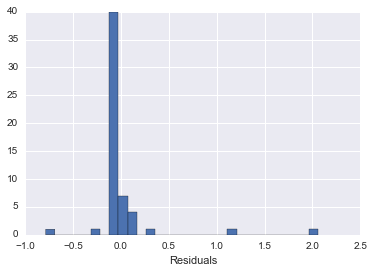

In [30]:
# This is a histogram that shows the distribution of the residuals
# Notice that they center on zero, this is important for the linear regression to be correct
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')

### **KNOWLEDGE CHECK**

Why should we inspect our residuals when building models?

<!-- 
- In linear models, residual error must be normal with a mean and median close to zero to get correct coefficients
- For all models you want your residuals to center on zero since it just means you are making good predictions
- Individual residuals are useful to see the error of specific points and can show trends that we are missing in our model
-->

## MEAN SQUARED ERROR (MSE)

Residuals tell us about individual points, but it doesn’t provide an overall picture to help us optimize the model.

**We need a metric to summarize the error in our model into one value.**

To calculate MSE:

1. Calculate the residual (difference between each target y and the model’s predicted value, y-hat).

2. Square each residual.

3. Take the mean of the squared residual errors.

$$MSE = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y}_i)^2$$
$$MSE = E[(y_i - \hat{y}_i)^2]$$

sklearn’s metrics module includes a mean_squared_error function.
For example, two arrays of the same values would have an MSE of 0.

In [31]:
from sklearn import metrics
y = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1, 2, 3, 4, 5])

print 'MSE:', np.mean((y-y_pred)**2)
print 'MSE:', metrics.mean_squared_error(y, y_pred)

MSE: 0.0
MSE: 0.0


In [32]:
from sklearn import metrics
y = np.array([1, 2, 3, 4, 5])
y_pred = np.array([5, 4, 3, 2, 1])
print 'MSE:', np.mean((y-y_pred)**2)
print 'MSE:', metrics.mean_squared_error(y, y_pred)

MSE: 8.0
MSE: 8.0


### KNOWLEDGE CHECK

- What are the possible values for MSE?
- Do we want MSE to be 0 or very large?

<!--
Answer:
- MSE ranges from 0 to Infinity
- Ideally we want MSE to be closer to 0
  - In practice and MSE of 0 means you made a mistake because it's too good to be true
-->

# BREAK

# DEMO: CROSS VALIDATION 
Objective: Learn how to write the code for evaluating a model

We've covered the general idea of model evaluation:

Train our model on some of our data and test it on the rest of the data.

**How do we do this in practice?**

The general idea is to:
- Generate several models of the same type on different sections of the data
- Measure the performance of each
- Take the mean performance

This technique helps us swaps bias error for generalized error, describing previous trends accurately enough to extend to future trends.

In other words, we trade off performance on our current dataset so we can generalize to future data that is collected in a similar manner.

![Cross Validation](assets/images/crossval.png)

### KNOWLEDGE CHECK
- Is there any row of data that we have not used for testing during cross-validation?

<!--
Answer: We eventually use all the rows for testing, but we never test and train on the same row at the same time.
-->

We will:
- Use k-fold cross validation
- Split the data into k group
- Train the model on all segments except one
- Test model performance on the remaining set

If k = 5, split the data into five segments and generate five models

In [33]:
from sklearn import cross_validation, metrics
bikeshare = pd.read_csv('assets/dataset/bikeshare/bikeshare.csv')
# Make dummy variables for weather situation
weather = pd.get_dummies(bikeshare['weathersit'], prefix='weather')
modeldata = bikeshare.join(weather[['weather_1', 'weather_2', 'weather_3']])

In [72]:
X = modeldata[['temp','season']]
y = bikeshare.casual
lm = linear_model.LinearRegression().fit(X, y)
y_pred = lm.predict(X)
scores = cross_validation.cross_val_score(lm, X, y, cv = 5, scoring='mean_squared_error')
# We use the negative of scores because sklearn uses negative mean_squared_error for its own reasons

print 'In Sample MSE:', metrics.mean_squared_error(y, y_pred)
print 'Out of Sample MSE:', np.mean(-scores)
print lm.coef_

In Sample MSE: 1915.88814454
Out of Sample MSE: 2030.84899304
[ 119.74103146   -1.14510938]


In [73]:
-scores

array([  788.11265971,  2189.32333628,   603.76751981,  3822.76911331,
        2750.27233607])

In [39]:
lm.coef_

array([ 112.31510989,  -80.74394487,   11.8600641 ])

In [35]:
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### EXERCISE: TEST FOR OVERFITTING
Use the above code to see if you can add a variable to X that makes the in-sample MSE better, but the out-of-sample MSE worse

HINT: Think about something that's improperly coded for linear regression

In [ ]:
# Write some code here for the exercise 
# Feel free to copy the above example
# Try not to copy and paste too much

### CROSS VALIDATION THE HARD WAY

In [ ]:
# As always there's a harder way to do this that gives more flexibility
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=False)
scores = []
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    scores.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))

print np.mean(scores)

### NOTE

If you are familiar with AIC and BIC, you should appreciate that selecting a model that minimizes its cross-val score is the same as selecting a model that minimizes its BIC. There is another similar procedure called Leave-One-Out Cross-Validation that is the same as minimizing the AIC.

# BIAS-VARIANCE TRADEOFF

We've noted that by allowing the bias on our training data to increase we can improve the reliability of our model on future data

This leads to a more general notion of the Bias-Variance Tradeoff

This is a conceptual topic that isn't immediately practical

It isn't immediately possible to measure bias and variance, but it's crucial to understand their relationship.

### THE SETUP

Consider a true relationship in the world, not the data we collect about it, but the real thing that we can't fully measure.

The are true values for the outcome, there are true predictors of that outcome, and there is a true relationship.
$$Y = f(X) + \epsilon$$

$Y$ is the outcome, $X$ shows predictors, and $\epsilon$ is noise that can't be explained

Unfortunately, we can only guess at what that relationship is
$$Y = \hat{f}(X) + \epsilon$$
$\hat{f}$ is our version of the model

The expected squared prediction error should look familiar, it's just the MSE, but we give it a fancy name for this context:
$$Err(X) = E[(Y-\hat{f}(x))^2]$$

This error can be composed into 3 components:
- **Bias** - How similar is our model to the true model
- **Variance** - How much does our model vary when it's retrain on new data
- **Irreducible Error** - Unexplainable noise in the relationship

$$Err(X) = Bias^2 + Variance + Irreducible Error$$
$$Err(x) = (E[\hat{f}(X)]-f(X))^2 + E[(\hat{f}(x) - E[\hat{f}(X)])^2] + \sigma_e^2$$

### KNOWLEDGE CHECK
- What should the bias be for a perfect model?
- What should the variance be for a perfect model?

<!--
Answer: Ideally you have no prediction error and your bias would be 0 and you variance would be 0. Maybe there is some irreducible error that can't be accounted for.
-->

### CONSIDER BIAS AND VARIANCE
Objective: Discuss the bias variance tradeoff and how it relates to cross-validation

Bias and Variance decomposition only makes sense with a batch of models, so let's simulate that.

A simple linear regression can't explain relationships very precisely, but it doesn't change much on new data

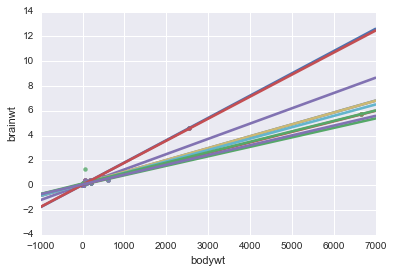

In [76]:
for i in range(10):
    sns.regplot('bodywt', 'brainwt', mammals.sample(20), order=1, ci=None)

### KNOWLEDGE CHECK
Are linear models generally low bias models?

<!--
Answer: No, they are generally high bias because it's hard to accurately explain the world using only lines. They do tend to have low variance relative to other models as well.
-->

We can try a more complex model, polynomial regression. As we've seen before, this can fit more arbitrary curves. However, when we run several iterations the results vary quite widely.

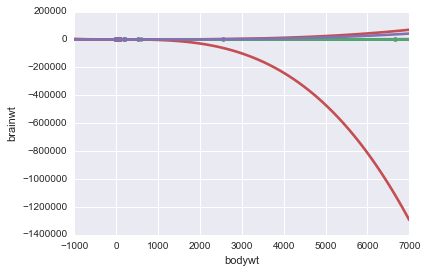

In [79]:
for i in range(10):
    sns.regplot('bodywt', 'brainwt', mammals.sample(20), order=3, ci=None)

We can purposely increase or decrease the complexity of a model to increase of decrease its bias. This also inversely changes the variance of the model. In other words, we can trade bias for variance and vice versa

![bias-variance](assets/images/bias-variance.jpg)

![The Bias Variance Trade-off](assets/images/bias-variance-tradeoff.png)

**So, what do we mean by model complexity?**

That's actually a tricky question. Roughly, how arbitrary of a relationship can the model fit? This will usually relate to how many paramters a model has to tune or how many data points it uses in determining a prediction. 

##### Another, partial, way to think about it is overfitting and underfitting

![low-middle-high](assets/images/low-middle-high.png)

## KNOWLEDGE CHECK

Which of the following scenarios would be better for a weatherman?
Knowing that I can very accurately "predict" the temperature outside from previous days perfectly, but be 20-30 degrees off for future days
Knowing that I can accurately predict the general trend of the temperate outside from previous days, and therefore am at most only 10 degrees off on future days

<!--
Answer: We want to be more accurate on future days, not much value in predicting the past
-->

# BREAK

# REGULARIZATION
Objective: Learn how to deal with a large number of predictors in regression models

**Problem** 

We have too many variables in a linear regression and it is overfitting.

**Solution**

Take out the irrelevant variables and you'll get a better fit.

**Complication**

ARE YOU KIDDING!? I have 5,000 variables, that will take forever.

**Regularization** is a way to adjust the complexity of your models and protect your models against overfitting (being potentially biased and overconfident, not generalizing well).

Regularization becomes an additional weight to coefficients, *shrinking them closer to zero*.

L1 (Lasso Regression) adds the extra weight to coefficients, this will often bring the coefficient to zero.

L2 (Ridge Regression) adds the square of the extra weight to coefficients, this will bring coefficients to near zero, but will rarely get rid of them.

Use Lasso when you think many of your predictors are completely irrelevant and just take up space. In other words, use Lasso when you are betting on sparsity.

Use Ridge when you think you have a lot of redundancy. Meaning that you can linearly recombine your predictors into fewer variables. This is a lot like compression or dimensionality reduction.

#### INTERESTING MATH NOTE

In fact, it's exactly like compression and dimensionality reduction.

L1 regularization is equivalent to Bayesian Linear Regression with a mean zero Laplace prior for each coefficient. Which is also extremely similar to incremental forward-stepwise procedures for variable selection

L2 regularization is equivalent to Bayesian Linear Regression with a mean zero Gaussian prior for each coefficient. Which is also extremely similar to running PCA follow by regression.

For more information look at the Linear Regression and Dimensionality Reduction chapters of Elements of Statistical Learning

### KNOWLEDGE CHECK

We are working with the bikeshare data to predict riders over hours/days with a several features.

Should we use a ridge regression or a lasso regression?

Why?

<!--
It happens to be the case that most of our features are related to ridership so we don't want to get rid of any. Using Ridge may make the regression better by adjusting for multicollinearity and allow us to find an ideal level of bias
-->

## AN EXTREME EXAMPLE
What happens if I include a bunch of variables and accidently include the outcome (or an extremely similar variable) in the set of predictors?

In [80]:
from sklearn import cross_validation, metrics
bikeshare = pd.read_csv('assets/dataset/bikeshare/bikeshare.csv')
# Make dummy variables for weather situation
weather = pd.get_dummies(bikeshare['weathersit'], prefix='weather')
modeldata = bikeshare.join(weather[['weather_1', 'weather_2', 'weather_3']])
X = modeldata.drop(labels=['dteday'], axis=1)
y = modeldata.casual

In [81]:
X.columns

Index([u'instant', u'season', u'yr', u'mnth', u'hr', u'holiday', u'weekday',
       u'workingday', u'weathersit', u'temp', u'atemp', u'hum', u'windspeed',
       u'casual', u'registered', u'cnt', u'weather_1', u'weather_2',
       u'weather_3'],
      dtype='object')

In [82]:
lm = linear_model.LinearRegression().fit(X, y)
print metrics.mean_squared_error(y, lm.predict(X))

1.04291700433e-25


In [83]:
# Pair together column names and regression coefficients
zip(X.columns, lm.coef_)

[('instant', 8.6291367697765302e-17),
 ('season', -3.5110803153770576e-15),
 ('yr', -2.0677903833643541e-13),
 ('mnth', -1.4988010832439613e-14),
 ('hr', -3.039235529911366e-15),
 ('holiday', -2.0602009681569555e-14),
 ('weekday', -3.2482697087665713e-16),
 ('workingday', -1.5077023830800673e-14),
 ('weathersit', 7.3053542382073289e-15),
 ('temp', 8.7876754484295105e-15),
 ('atemp', 8.6305095015060118e-14),
 ('hum', -2.8975845160761349e-14),
 ('windspeed', 4.0215769082918573e-15),
 ('casual', 0.6666666666666663),
 ('registered', -0.3333333333333337),
 ('cnt', 0.33333333333333376),
 ('weather_1', -3.8472914090648125e-15),
 ('weather_2', 5.0653925498522767e-16),
 ('weather_3', 3.2206767634768152e-15)]

In [84]:
lassom = linear_model.Lasso(alpha=10).fit(X, y)
print metrics.mean_squared_error(y, lm.predict(X))

1.04291700433e-25


In [85]:
zip(X.columns, lassom.coef_)

[('instant', 5.4659454466419177e-07),
 ('season', 0.0),
 ('yr', 0.0),
 ('mnth', 0.0),
 ('hr', 0.0),
 ('holiday', 0.0),
 ('weekday', 0.0),
 ('workingday', -0.0),
 ('weathersit', -0.0),
 ('temp', 0.0),
 ('atemp', 0.0),
 ('hum', -0.0),
 ('windspeed', 0.0),
 ('casual', 0.99363736908841538),
 ('registered', 0.0),
 ('cnt', 0.00089308404267609534),
 ('weather_1', 0.0),
 ('weather_2', -0.0),
 ('weather_3', -0.0)]

### KNOWLEDGE CHECK

Once you get over the shock of how amazing that is.

- You might notice that the coefficient on casual ridership is .66 in the linear model, what would you expect that coefficient to be?
- Why is the linear regression answer different from the ideal answer?
- Does Lasso give a more reasonable result?

<!--
Answer: Well, you would hope that the relationship between casual and casual is one to one. 

That coefficient should be 1, but we lose the effect due to multicollinearity with all the other variables.

Lasso does way better because it effectively gets rid of the multicollinearity for us. It's usually not this simple
-->

### **It's not that simple**
- Need to find a good alpha parameter
 - Large alpha means heavier regularization forcing more coefficients to zero
- predictors/features need to be scaled so they have similar magnitudes for regularization to work properly
- You should scale within train-test split or cross-validation
  - If you scale on your whole dataset, you have unfair information about means and standard deviations of your testing data

## WHERE REGULARIZATION MAKES SENSE
Objective: Get a better sense of what actually happens during regularization

### UNDERSTANDING REGULARIZATION EFFECTS


Let’s test a variety of alpha weights for Ridge Regression on the bikeshare data.

In [86]:
from sklearn import cross_validation, metrics
bikeshare = pd.read_csv('assets/dataset/bikeshare/bikeshare.csv')
# Make dummy variables for weather situation
weather = pd.get_dummies(bikeshare['weathersit'], prefix='weather')
modeldata = bikeshare.join(weather[['weather_1', 'weather_2', 'weather_3']])
X = modeldata[['temp', 'hum']]
y = modeldata.casual

In [87]:
alphas = np.logspace(-10, 10, 21)
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(X, y)
    print "Coefficients: ", lm.coef_
    print "MSE: ", metrics.mean_squared_error(y, lm.predict(X))
    
# What happens to the weights of the coefficients as alpha increases?  
# What happens to the error as alpha increases?

Alpha: 1e-10
Coefficients:  [ 112.02457031  -80.87301833]
MSE:  1675.09316612
Alpha: 1e-09
Coefficients:  [ 112.02457031  -80.87301833]
MSE:  1675.09316612
Alpha: 1e-08
Coefficients:  [ 112.02457031  -80.87301833]
MSE:  1675.09316612
Alpha: 1e-07
Coefficients:  [ 112.02457029  -80.87301832]
MSE:  1675.09316612
Alpha: 1e-06
Coefficients:  [ 112.02457014  -80.87301821]
MSE:  1675.09316612
Alpha: 1e-05
Coefficients:  [ 112.02456865  -80.87301719]
MSE:  1675.09316612
Alpha: 0.0001
Coefficients:  [ 112.02455372  -80.87300698]
MSE:  1675.09316612
Alpha: 0.001
Coefficients:  [ 112.02440439  -80.87290487]
MSE:  1675.09316612
Alpha: 0.01
Coefficients:  [ 112.02291118  -80.87188379]
MSE:  1675.09316628
Alpha: 0.1
Coefficients:  [ 112.00798119  -80.86167437]
MSE:  1675.09318209
Alpha: 1.0
Coefficients:  [ 111.85890051  -80.75972093]
MSE:  1675.09475893
Alpha: 10.0
Coefficients:  [ 110.38969207  -79.75406957]
MSE:  1675.24836171
Alpha: 100.0
Coefficients:  [ 97.57779825 -70.91705081]
MSE:  1687.26

## KNOWLEDGE CHECK

1. Why is regularization important? 
2. What does it protect against and how?
3. What is the regularization hyperparameter called?


## PAIR PROGRAMMING: GRID SEARCH CV, SOLVING FOR ALPHA
Objective: Learn how to automate hyperparameter searches

In [ ]:
Explore the code below, I'll give you a tour first, and find a lower MSE than 2535

In [88]:
# WE CAN MAKE TUNING ALPHA EASIER WITH GRID SEARCH!
# Grid search exhaustively searches through all given options to find the best solution.  Grid search will try all combos given in param_grid.

param_grid = {
    'intercept': [True, False],
    'alpha': [1, 2, 3],
}

This param grid has six different options:
- intercept = True, alpha = 1
- intercept = True, alpha = 2
- intercept = True, alpha = 3
- intercept = False, alpha = 1
- intercept = False, alpha = 2
- intercept = False, alpha = 3

In [89]:
from sklearn import grid_search

alphas = np.logspace(5, 10, 4)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

In [90]:
gs.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e+05,   4.64159e+06,   2.15443e+08,   1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [91]:
print -gs.best_score_ # mean squared error here comes in negative, so let's make it positive.

2535.35853444


In [92]:
print gs.best_estimator_ # explains which grid_search setup worked best

Ridge(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [93]:
print gs.grid_scores_ # shows all the grid pairings and their performances.

[mean: -2535.35853, std: 963.21173, params: {'alpha': 100000.0}, mean: -2542.28002, std: 964.09507, params: {'alpha': 4641588.8336127819}, mean: -2542.43017, std: 964.11410, params: {'alpha': 215443469.00318867}, mean: -2542.43340, std: 964.11451, params: {'alpha': 10000000000.0}]


# HOW DO WE ACTUALLY SOLVE A MODEL?
Objective: Introduce how model optimization works and how our code solves for parameters. Use this to lead into SGDRegressor that will serve as a very powerful tool in student's tookit

### How do we minimize error?

The regression method we’ve used is called “Ordinary Least Squares”.

This means that given a matrix X, solve for the least amount of square error for y.

How do we find the actual numbers for the coefficients though?

### Numerical Optimization
- We use optimization techniques that minimize a cost function that tells us how well our model is doing. Again, the cost function is basically MSE.
- We could possibly do this with a grid search, trying several evenly spaced values, this is a fundamental optimization technique
- More typically we use a gradient method
 - You might remember newton's method from calculus class
 - These are much faster for finding the optimal parameters
 - There are many approaches, but we will discuss only two

### Gradient Descent

Gradient Descent is a particular gradient optimization method that can help us minimize error.

How Gradient Descent works:
- A random linear solution is provided as a starting point
- The solver attempts to find a next “step”: By looking for a new set of points to evaluate
- If the solver finds a better solution (i.e. lower MSE), this is the new starting point.
- Repeat these steps until the performance is optimized and no “next steps” perform better.  The size of steps will shrink over time.


**Hypothesis** - This is our model, in this case linear regression:
$$h_{\theta}(x) = \theta_0 + \theta_1\bar{x}$$
**Parameters** - What are we solving for ... regression coefficients!:
$$\theta_0, \theta_1$$
**Cost Function** - How should we measure distance?:
$$J(\theta_0, \theta_1) = \frac{1}{2m}\sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})^2$$
**Goal**
$$\min_{\theta_0, \theta_1} J(\theta_0, \theta_1)$$

What does this actually mean? Minimize the residuals or the distance between our predictions and actual data
$$\sum(\hat{y} - y)^2$$

![Minimization](assets/images/minimization.png)

Gradient Descent could solve for a local minimum instead of a global minimum.

This is because gradient methods use the hill-climbing heuristic, if you start on the wrong hill, you'll never find the tallest hill. (Ok, valley finding in this case)

A local minimum is confined to a very specific subset of solutions.  The global minimum considers all solutions.  These could be equal, but that’s not always true.

![local vs global](assets/images/local-global.png)

### Why should I ever care?
- If you create custom models that don't rely on a package you need to know how to solve them
  - I have been forced to do this at times because packages were not available in the given production environment
- Certain methods are good for dealing with large amounts of data
  - We will see an example
- Neural networks are finicky in terms of optimization because they have a lot of parameters
  - Can only find local optimum, although they are all equally good
  - You need a sense of how gradient methods work to feel comfortable with neural nets

## APPLICATION OF GRADIENT DESCENT

Typically when you solve a Linear or Logistic regression your statistics software uses a optimization method called L-BFGS which works a lot like Gradient Descent

The problem with both of these methods is that they can be slow because they read ALL of your data on every iteration

It turns out that you can get pretty good answers just reading one row at a time or a few samples to approximate your MSE and find a next step

We call this Stochastic Gradient Descent or sometimes Mini-Batch Gradient Descent if we sample multiple rows

## Stochastic Gradient Descent

Stochastic Gradient Descent works best when:

- We are working with a large dataset.  Smaller datasets are more prone to error.
- Data is cleaned up and normalized
  - Normalized meaning scaled and centered.
  - Substract the mean and divide by standard deviation
  - This holds true for any gradient based method, including regressions in your statistics software

## Stochastic Gradient Descent in Sklearn

In [ ]:
lm = linear_model.LinearRegression()
lm.fit(X, y)
print lm.score(X, y)
print metrics.mean_squared_error(y, lm.predict(X))

In [ ]:
lm = linear_model.SGDRegressor()
lm.fit(X, y)
print lm.score(X, y) # R-squared
print metrics.mean_squared_error(y, lm.predict(X))

### EXERCISE (If there's time)
Play around with some of the parameters to SGDRegressor to see how MSE change

Feel free to view the coefficients and residuals to get better feedback

If you want, the bikeshare data is still loaded in so you can try to predict casual ridership based on other factors, how low of an MSE you can get? Start small with one variable and improve from there.

Stochastic Gradient Descent can be tuned with 

**the learning rate**:  how aggressively we solve the problem

**epsilon**:  at what point do we say the error margin is acceptable

**iterations**:  when should be we stop no matter what


You will also notice that you can modify the loss functions and regularization parameters
- This can be very useful for dealing with outliers if you choose a loss function like Huber of LAD which are not as sensitive to outliers

There is a classifer version as well. We will talk about classification next class.

[Check the docs!](http://scikit-learn.org/stable/modules/sgd.html)

# TOPIC REVIEW

- What's the (typical) range of r-squared?
- What's the range of mean squared error?
- How would changing the scale or interpretation of y (your target variable) effect mean squared error?
- What's cross validation, and why do we use it in machine learning?
- What is error due to bias? What is error due to variance? Which is better for a model to have, if it had to have one?
- How does gradient descent try a different approach to minimizing error?

# ADDITIONAL RESOURCES
- Seriously, the sklearn documentation is incredible
  - Go through their User Guide at least once at some point
  - For now these may be interesting
  - http://scikit-learn.org/stable/modules/sgd.html
  - http://scikit-learn.org/stable/modules/linear_model.html
  - http://scikit-learn.org/stable/modules/feature_selection.html
- Check out the cross-validated FAQs
 - Regularization: http://stats.stackexchange.com/questions/tagged/regularization?sort=frequent&pageSize=15
 - Multicollinearity:  http://stats.stackexchange.com/questions/tagged/multicollinearity?sort=frequent&pageSize=15
 - Log Transforms: http://stats.stackexchange.com/questions/tagged/distributions?sort=frequent&pageSize=15
 - Regression: http://stats.stackexchange.com/questions/tagged/multiple-regression?sort=frequent&pageSize=15
 - Speaking of which, I need to go back and refresh my memory on some of those
- Big Data in your future? Check out Vowpal Wabbit and relate it back to SGDRegressor and SGDClassifer
  - Computationally better than sklearn and works with huge datasets, but not even remotely as friendly
  - It's OK, the concepts will transfer and the syntax can be figured out
  - https://en.wikipedia.org/wiki/Vowpal_Wabbit
  - Even if not, check out the wikipedia article and realize that you half know what it is talking about and have access to new resources
- Data can't fit into RAM and Vowpal Wabbit looks too painful?
  - SGD can help
  - http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html
  
Again, you can slack whatever questions you want, even if you want help deciphering an FAQ post from cross-validated. If you have a topic you are interested in from this notebook, John and I can add to handy-resources. We've been exposed to a lot out of necessity and listing all related resources would take some space.

# BEFORE NEXT CLASS

- Homework: Project: Final Project, Deliverable 1 DUE next class
  - 2-3 minute presentation on 3 potential project questions and related datasets
  - slack slides or put them up on your GitHub and send me a link
- If dummy variables still confuse you, try going through this notebook
  - https://github.com/ga-students/DS-DC-14/blob/master/lessons/lesson-07/code/starter-code/pre-work-dummy-vars.ipynb



# EXIT TICKET: Evaluating Model Fit
http://goo.gl/forms/gG5qAw9QljgkHC2q1